In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter


features = pd.read_csv('results.csv', delimiter=',') 
target = pd.read_csv('unit_comitment.csv', delimiter=',')

In [2]:
features.head()

,hour,generation 1,generation 2,generation 3,wind generation 1,wind generation 2,load 1,load 2,load 3,epsilon 1,...,transmission_up_binding_L3,transmission_down_binding_L3,transmission_up_binding_L4,transmission_down_binding_L4,transmission_up_binding_L5,transmission_down_binding_L5,transmission_up_binding_L6,transmission_down_binding_L6,transmission_up_binding_L7,transmission_down_binding_L7
0,0,100.0,0.0,10.000000,0.0,5.044859,7.190304,57.522429,50.332126,0.0,...,False,False,False,False,False,False,False,False,False,False
1,1,100.0,0.0,10.000000,0.0,7.889218,7.368076,58.944609,51.576533,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100.0,0.0,10.000000,0.0,12.197143,7.637321,61.098571,53.461250,0.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100.0,0.0,10.000000,0.0,5.828420,7.239276,57.914210,50.674934,0.0,...,False,False,False,False,False,False,False,False,False,False
4,4,100.0,0.0,11.403747,0.0,18.951910,8.147229,65.177829,57.030600,0.0,...,True,False,False,False,False,False,False,False,False,False


### Data Preprocessing Summary

In this data preprocessing step, we focused on handling class imbalance issues and preparing the data for machine learning models, particularly for the unit commitment classification problem. The dataset consists of features such as wind generation and load values, and binary target variables representing the operational status of generators (G2 and G3).

1. **Data Splitting**: 
   - We divided the dataset into training, validation, and testing sets using `train_test_split`, ensuring that the class distribution in the target variables was preserved through stratification. This helps maintain the representation of both majority and minority classes in all subsets.

2. **Class Imbalance Handling with SMOTE**:
   - SMOTE (Synthetic Minority Oversampling Technique) was applied to the training data for `G2` and `G3` to address class imbalance issues. This technique generates synthetic samples for the minority class by interpolating between existing samples, thereby balancing the dataset. The class distributions were printed before and after SMOTE to demonstrate the changes.

3. **Scaling Features**:
   - Feature scaling was applied using `StandardScaler` to normalize the input data. This ensures that all features contribute equally to the model's performance and are measured on the same scale. Scaling was performed separately for each unit (`G1`, `G2`, `G3`) to accommodate the preprocessing applied (e.g., SMOTE for G2 and G3).

4. **Visualization**:
   - Scatter plots were generated to visualize the feature distributions for two selected features (`wind generation 1` and `load 1`) before and after applying SMOTE. This helps assess the impact of SMOTE on the data's structure and the separation between classes.

This preprocessing ensures that the training data is well-balanced and normalized, providing a robust foundation for building machine learning models to predict generator status.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Define features and labels
features = features[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]
targets = target[['G2', 'G3']]

X = features
y = target

# Units to consider for SMOTE
units_to_consider = ['G1', 'G2', 'G3']

# Split data into training, validation, and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y[['G2', 'G3']], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp[['G2', 'G3']], random_state=42)

# Initialize dictionaries for resampled and scaled data
X_train_resampled, y_train_resampled = {}, {}
X_train_scaled, X_val_scaled, X_test_scaled = {}, {}, {}

# Apply SMOTE for G2 and G3, and keep G1 unchanged
for unit in units_to_consider:
    if unit in ['G2', 'G3']:
        print(f"\nBefore SMOTE for {unit}: {Counter(y_train[unit])}")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train[unit])
        X_train_resampled[unit] = X_res
        y_train_resampled[unit] = y_res
        print(f"After SMOTE for {unit}: {Counter(y_res)}")
    else:
        # For G1, simply use the original training data
        X_train_resampled[unit] = X_train
        y_train_resampled[unit] = y_train[unit]

# Scaling the data for all units
scaler = StandardScaler()
for unit in units_to_consider:
    if unit in ['G2', 'G3']:
        # For G2 and G3, scale the resampled data
        X_train_scaled[unit] = scaler.fit_transform(X_train_resampled[unit])
    else:
        # For G1, scale the original data
        X_train_scaled[unit] = scaler.fit_transform(X_train)

    # Scale validation and test sets (same for all units)
    X_val_scaled[unit] = scaler.transform(X_val)
    X_test_scaled[unit] = scaler.transform(X_test)

# Display split sizes
print("\nData split sizes:")
for unit in units_to_consider:
    if unit in ['G2', 'G3']:
        print(f"{unit} - Training (resampled): {X_train_resampled[unit].shape}, Validation: {X_val.shape}, Testing: {X_test.shape}")
    else:
        print(f"{unit} - Training: {X_train.shape}, Validation: {X_val.shape}, Testing: {X_test.shape}")



Before SMOTE for G2: Counter({0.0: 1216, 1.0: 464})
After SMOTE for G2: Counter({0.0: 1216, 1.0: 1216})

Before SMOTE for G3: Counter({1.0: 1618, 0.0: 62})
After SMOTE for G3: Counter({1.0: 1618, 0.0: 1618})

Data split sizes:
G1 - Training: (1680, 5), Validation: (360, 5), Testing: (360, 5)
G2 - Training (resampled): (2432, 5), Validation: (360, 5), Testing: (360, 5)
G3 - Training (resampled): (3236, 5), Validation: (360, 5), Testing: (360, 5)


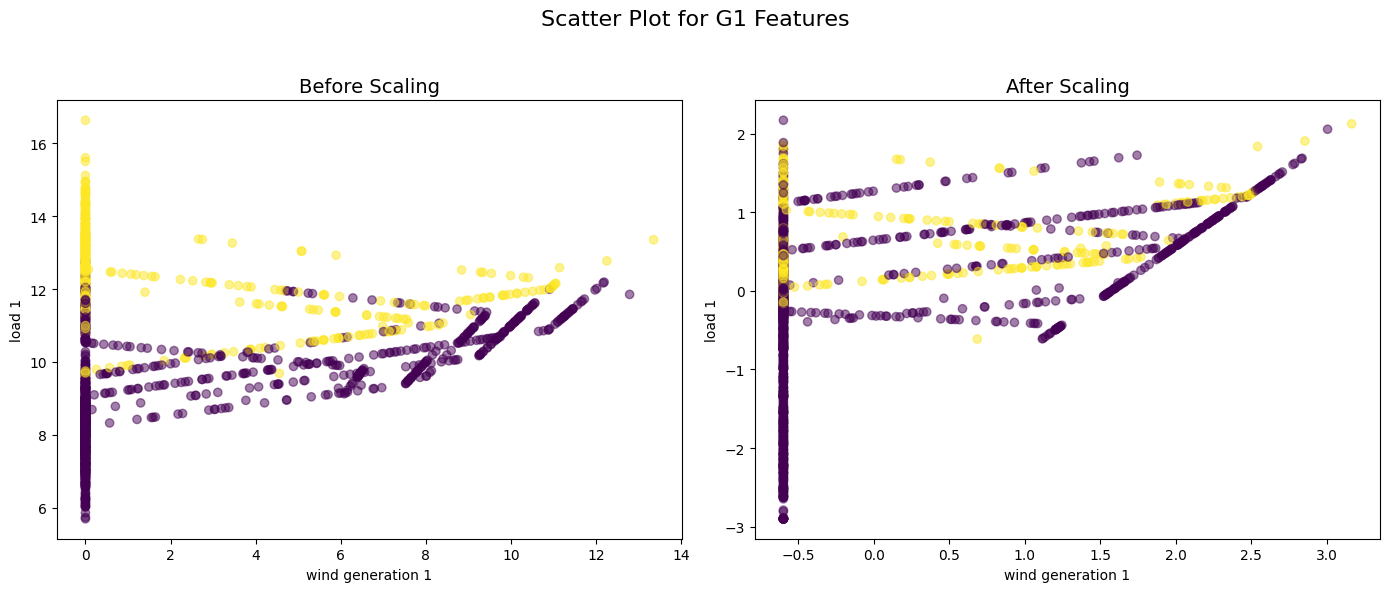

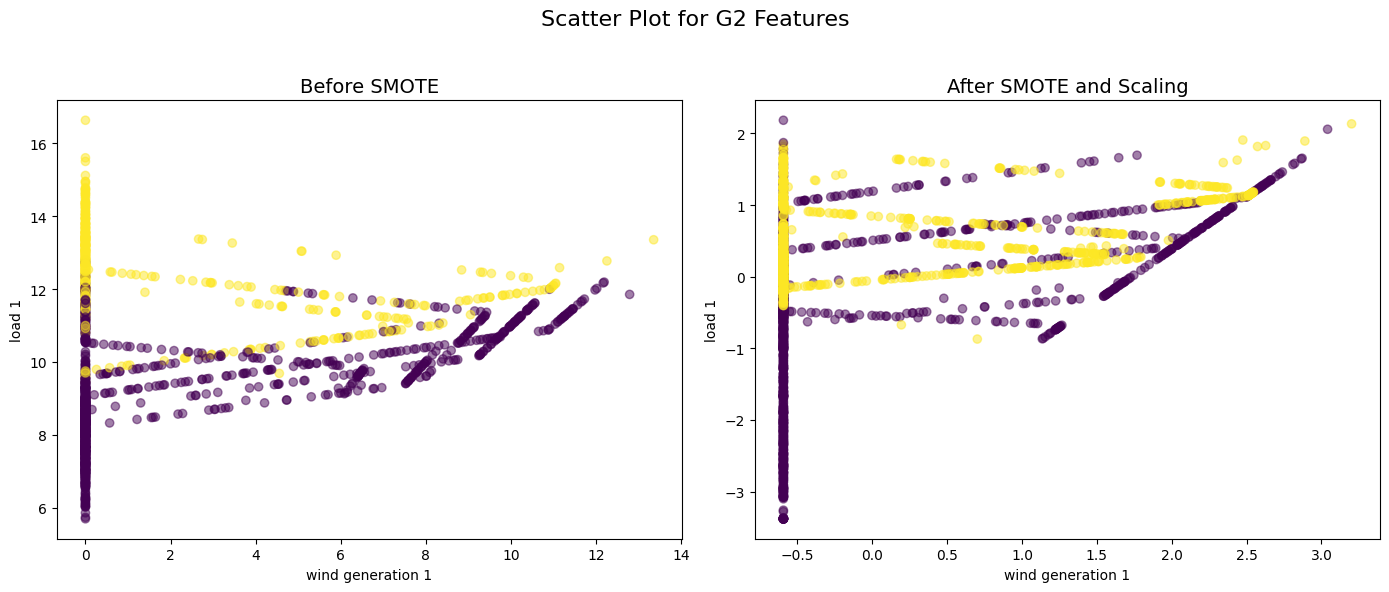

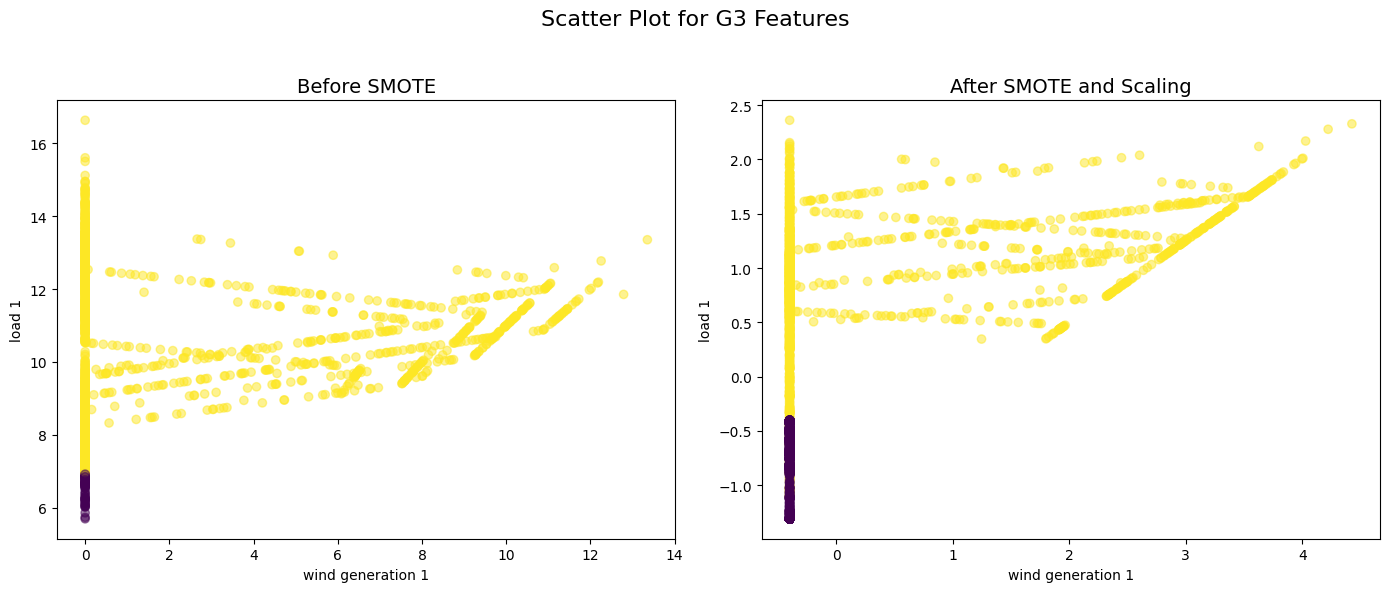

In [4]:
# Features to plot
feature_1 = 'wind generation 1'
feature_2 = 'load 1'

# Units to plot
units = ['G1', 'G2', 'G3']

# Create scatter plots for each unit
for unit in units:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Scatter Plot for {unit} Features", fontsize=16)

    if unit == 'G1':
        # Before scaling
        ax[0].scatter(X_train[feature_1], X_train[feature_2], c=y_train['G2'], alpha=0.5, cmap='viridis')
        ax[0].set_title("Before Scaling", fontsize=14)
        ax[0].set_xlabel(feature_1)
        ax[0].set_ylabel(feature_2)

        # After scaling
        ax[1].scatter(X_train_scaled[unit][:, 0], X_train_scaled[unit][:, 1], c=y_train['G2'], alpha=0.5, cmap='viridis')
        ax[1].set_title("After Scaling", fontsize=14)
        ax[1].set_xlabel(feature_1)
        ax[1].set_ylabel(feature_2)
    else:
        # Before SMOTE
        ax[0].scatter(X_train[feature_1], X_train[feature_2], c=y_train[unit], alpha=0.5, cmap='viridis')
        ax[0].set_title("Before SMOTE", fontsize=14)
        ax[0].set_xlabel(feature_1)
        ax[0].set_ylabel(feature_2)

        # After SMOTE and scaling
        ax[1].scatter(X_train_scaled[unit][:, 0], X_train_scaled[unit][:, 1], c=y_train_resampled[unit], alpha=0.5, cmap='viridis')
        ax[1].set_title("After SMOTE and Scaling", fontsize=14)
        ax[1].set_xlabel(feature_1)
        ax[1].set_ylabel(feature_2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Pairplot for Original Data (Before SMOTE):


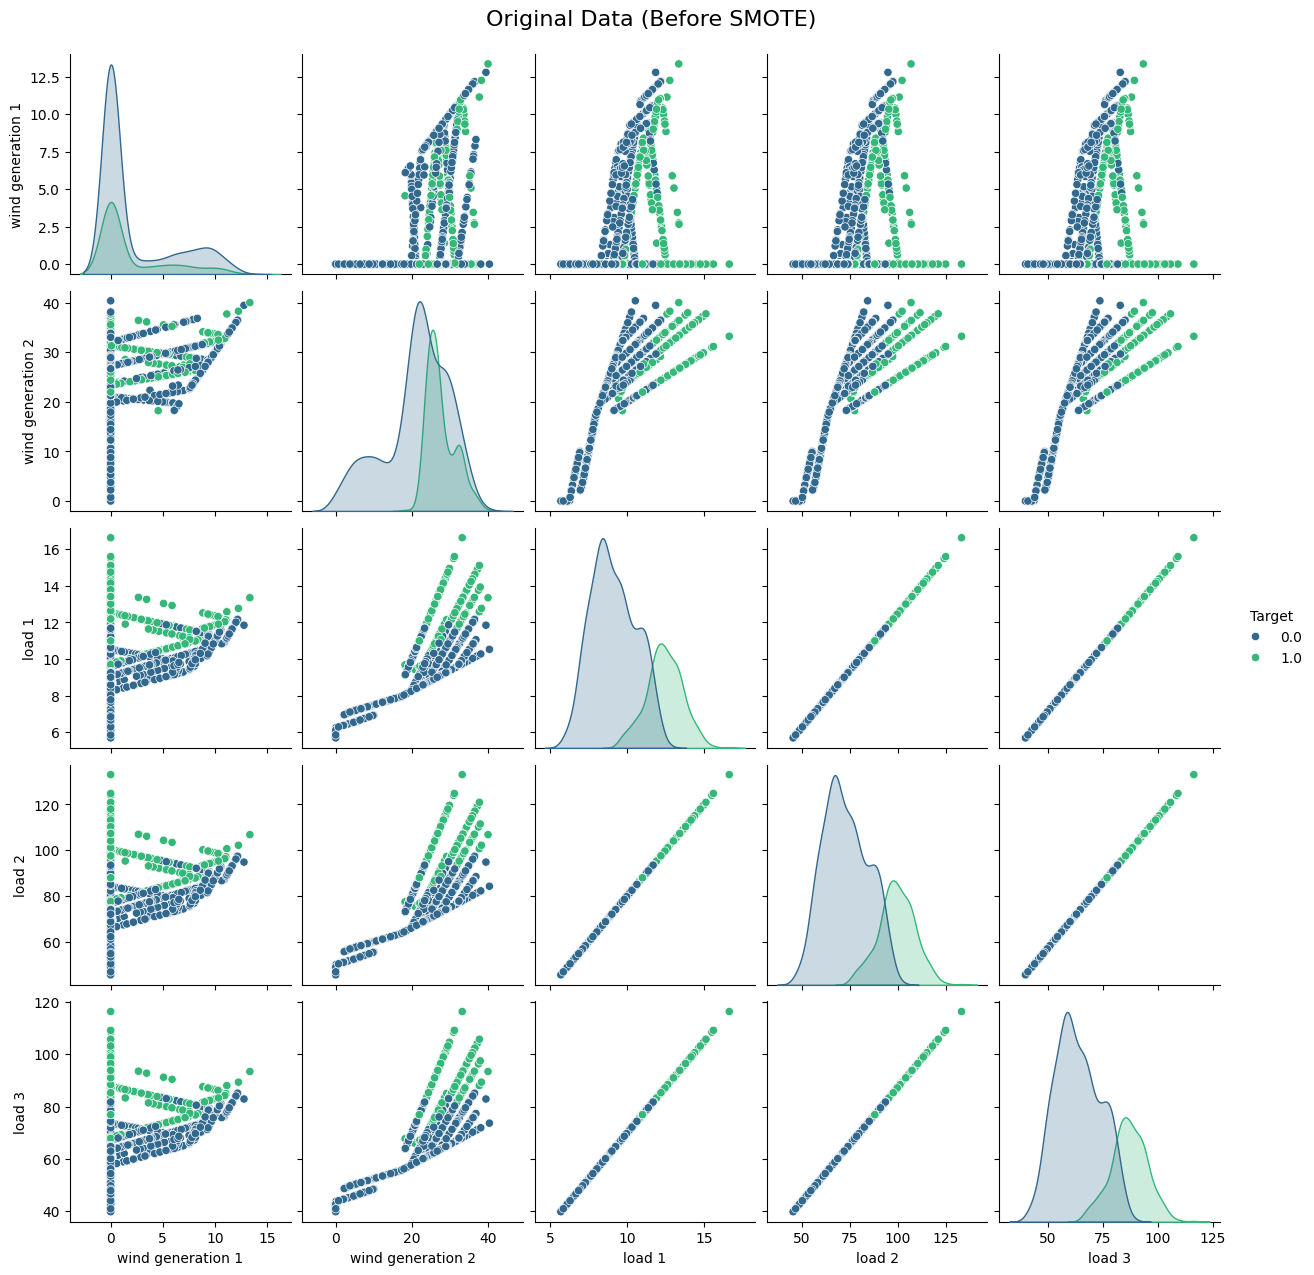

Pairplot for Resampled Data (After SMOTE):


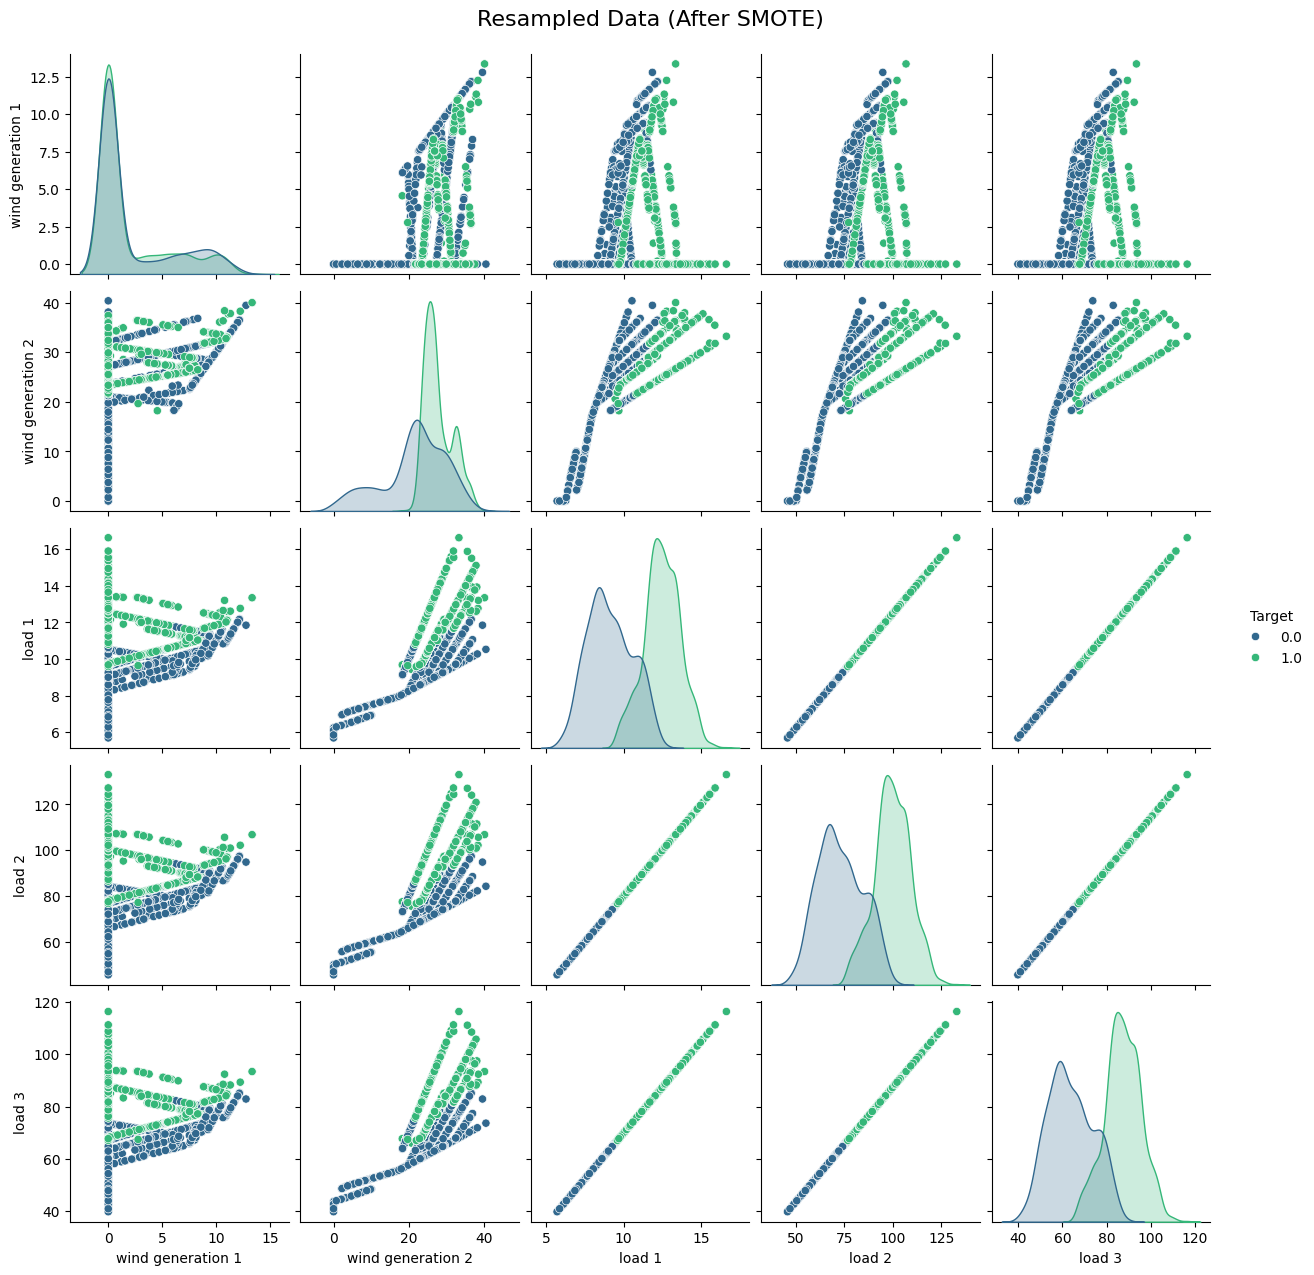

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the original training data
df_original = pd.DataFrame(X_train, columns=features.columns)
df_original['Target'] = y_train['G2']  # Adjust for the specific target column

# Create a DataFrame for the resampled training data
df_resampled = pd.DataFrame(X_train_resampled['G2'], columns=features.columns)
df_resampled['Target'] = y_train_resampled['G2']

# Plot pairplot for the original data
print("Pairplot for Original Data (Before SMOTE):")
sns.pairplot(df_original, hue='Target', palette='viridis', diag_kind='kde')
plt.suptitle("Original Data (Before SMOTE)", y=1.02, fontsize=16)
plt.show()

# Plot pairplot for the resampled data
print("Pairplot for Resampled Data (After SMOTE):")
sns.pairplot(df_resampled, hue='Target', palette='viridis', diag_kind='kde')
plt.suptitle("Resampled Data (After SMOTE)", y=1.02, fontsize=16)
plt.show()


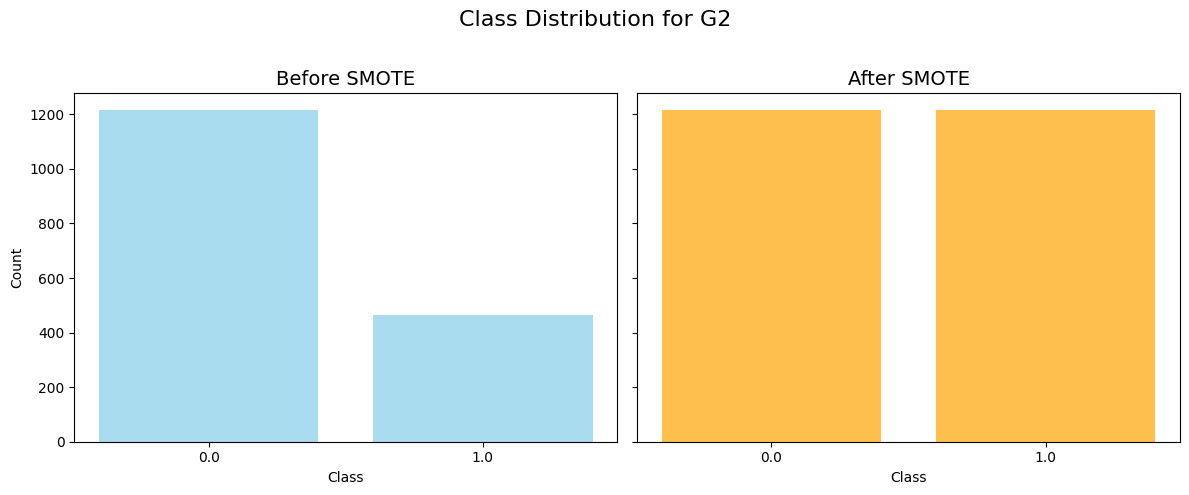

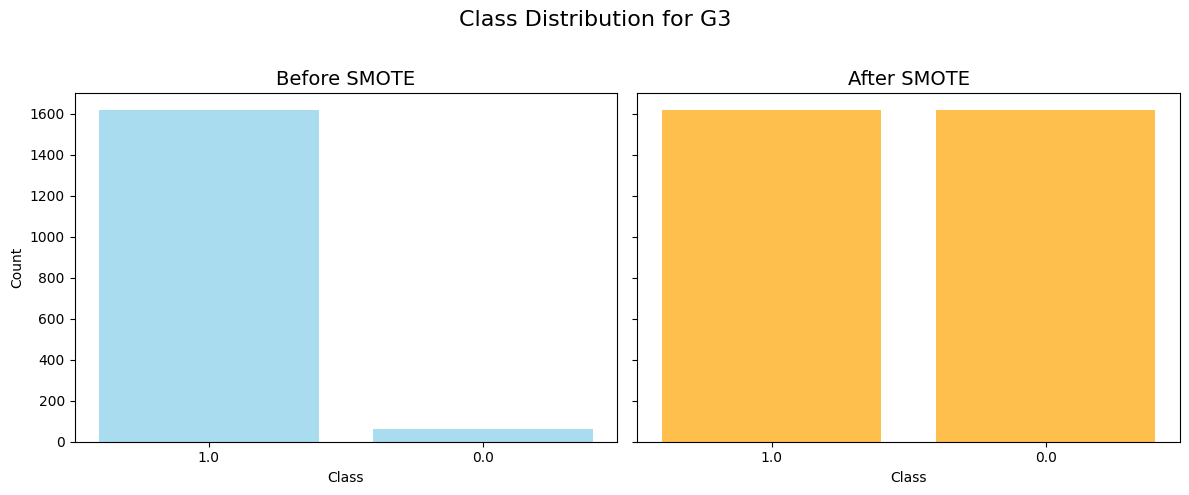

In [6]:
# Function to plot the data distribution
def plot_distribution(original_counts, smote_counts, unit_name):
    labels = list(original_counts.keys())
    before_counts = list(original_counts.values())
    after_counts = list(smote_counts.values())
    
    x = range(len(labels))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle(f"Class Distribution for {unit_name}", fontsize=16)
    
    # Before SMOTE
    ax[0].bar(x, before_counts, color='skyblue', alpha=0.7)
    ax[0].set_title("Before SMOTE", fontsize=14)
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(labels)
    ax[0].set_xlabel("Class")
    ax[0].set_ylabel("Count")
    
    # After SMOTE
    ax[1].bar(x, after_counts, color='orange', alpha=0.7)
    ax[1].set_title("After SMOTE", fontsize=14)
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(labels)
    ax[1].set_xlabel("Class")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot for each unit
for unit in ['G2', 'G3']:
    original_counts = Counter(y_train[unit])
    smote = SMOTE(random_state=42)
    _, y_res = smote.fit_resample(X_train, y_train[unit])
    smote_counts = Counter(y_res)
    
    plot_distribution(original_counts, smote_counts, unit)


## Step 3 Classification:

In [7]:
# Check label distribution for each unit
for unit in ['G1', 'G2', 'G3']:
    print(f"Label distribution for {unit}:")
    print(y_train_resampled[unit].value_counts())
    print()


Label distribution for G1:
G1
1.0    1680
Name: count, dtype: int64

Label distribution for G2:
G2
0.0    1216
1.0    1216
Name: count, dtype: int64

Label distribution for G3:
G3
1.0    1618
0.0    1618
Name: count, dtype: int64



# Evaluation and Comparison of Classifier Performance

## Metrics for Evaluation:

### 1. **Accuracy**:
- **Definition**: The proportion of correct predictions out of the total number of samples.
- **Use Case**: Useful for understanding the overall correctness of the model's predictions.
- **Formula**: 
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### 2. **Precision**:
- **Definition**: The proportion of true positive predictions among all positive predictions.
- **Use Case**: Important for problems where minimizing false positives is critical.
- **Formula**:
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### 3. **Recall (Sensitivity/True Positive Rate)**:
- **Definition**: The proportion of actual positive cases that were correctly identified.
- **Use Case**: Useful when the focus is on minimizing false negatives.
- **Formula**:
$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### 4. **F1 Score**:
- **Definition**: The harmonic mean of precision and recall, balancing the trade-off between precision and recall.
- **Use Case**: A good metric when a balance between precision and recall is needed, especially in cases of imbalanced datasets.
- **Formula**:
$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 5. **Confusion Matrix**:
- **Definition**: A table showing the number of true positive, true negative, false positive, and false negative predictions.
- **Use Case**: Provides a complete view of how the model performs across different classes.



In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dictionary to store trained models for each unit
trained_models = {}

# Function to train and evaluate classifiers
def train_and_evaluate(X_train_dict, X_val_dict, y_train_dict, y_val, unit_name):
    # Handle different cases for G1, G2, and G3
    if unit_name == 'G1':
        X_train = X_train_dict[unit_name]
        y_train = y_train_dict[unit_name]
        X_val = X_val_dict[unit_name]
    else:
        X_train = X_train_dict[unit_name]
        y_train = y_train_dict[unit_name]
        X_val = X_val_dict[unit_name]

    # Check if the unit has samples for both classes
    if len(set(y_train)) < 2:
        print(f"Skipping training for {unit_name} as it only contains one class.")
        return

    # Dictionary to store models for this unit
    unit_models = {
        'Logistic Regression': LogisticRegression(),
        'SVM (RBF Kernel)': SVC(kernel='rbf'),
        'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=500, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42)
    }
    results = {}

    # Train and evaluate each model
    for model_name, model in unit_models.items():
        # Train the model
        model.fit(X_train, y_train)
        
        # Store the trained model
        trained_models[(unit_name, model_name)] = model
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y_val[unit_name], y_pred)
        precision = precision_score(y_val[unit_name], y_pred, zero_division=0)
        recall = recall_score(y_val[unit_name], y_pred, zero_division=0)
        f1 = f1_score(y_val[unit_name], y_pred, zero_division=0)
        
        # Store the results
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
        
        # Print the metrics
        print(f"\n{model_name} for {unit_name}:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
    
    return results

# Loop through each generating unit to train and evaluate models
for unit in ['G1', 'G2', 'G3']:
    print(f"\nTraining classifiers for {unit}:")
    train_and_evaluate(X_train_scaled, X_val_scaled, y_train_resampled if unit != 'G1' else y_train, y_val, unit)



Training classifiers for G1:
Skipping training for G1 as it only contains one class.

Training classifiers for G2:

Logistic Regression for G2:
Accuracy: 0.86
Precision: 0.70
Recall: 0.86
F1 Score: 0.77

SVM (RBF Kernel) for G2:
Accuracy: 0.93
Precision: 0.80
Recall: 0.99
F1 Score: 0.88

Random Forest for G2:
Accuracy: 0.93
Precision: 0.82
Recall: 0.95
F1 Score: 0.88

Gradient Boosting for G2:
Accuracy: 0.93
Precision: 0.83
Recall: 0.96
F1 Score: 0.89

Decision Tree for G2:
Accuracy: 0.92
Precision: 0.81
Recall: 0.94
F1 Score: 0.87

Training classifiers for G3:

Logistic Regression for G3:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

SVM (RBF Kernel) for G3:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Random Forest for G3:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Gradient Boosting for G3:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Decision Tree for G3:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [29]:
print(trained_models)

{('G2', 'Logistic Regression'): LogisticRegression(), ('G2', 'SVM (RBF Kernel)'): SVC(), ('G2', 'Random Forest'): RandomForestClassifier(n_estimators=500, random_state=42), ('G2', 'Gradient Boosting'): GradientBoostingClassifier(n_estimators=500, random_state=42), ('G2', 'Decision Tree'): DecisionTreeClassifier(random_state=42), ('G3', 'Logistic Regression'): LogisticRegression(), ('G3', 'SVM (RBF Kernel)'): SVC(), ('G3', 'Random Forest'): RandomForestClassifier(n_estimators=500, random_state=42), ('G3', 'Gradient Boosting'): GradientBoostingClassifier(n_estimators=500, random_state=42), ('G3', 'Decision Tree'): DecisionTreeClassifier(random_state=42)}


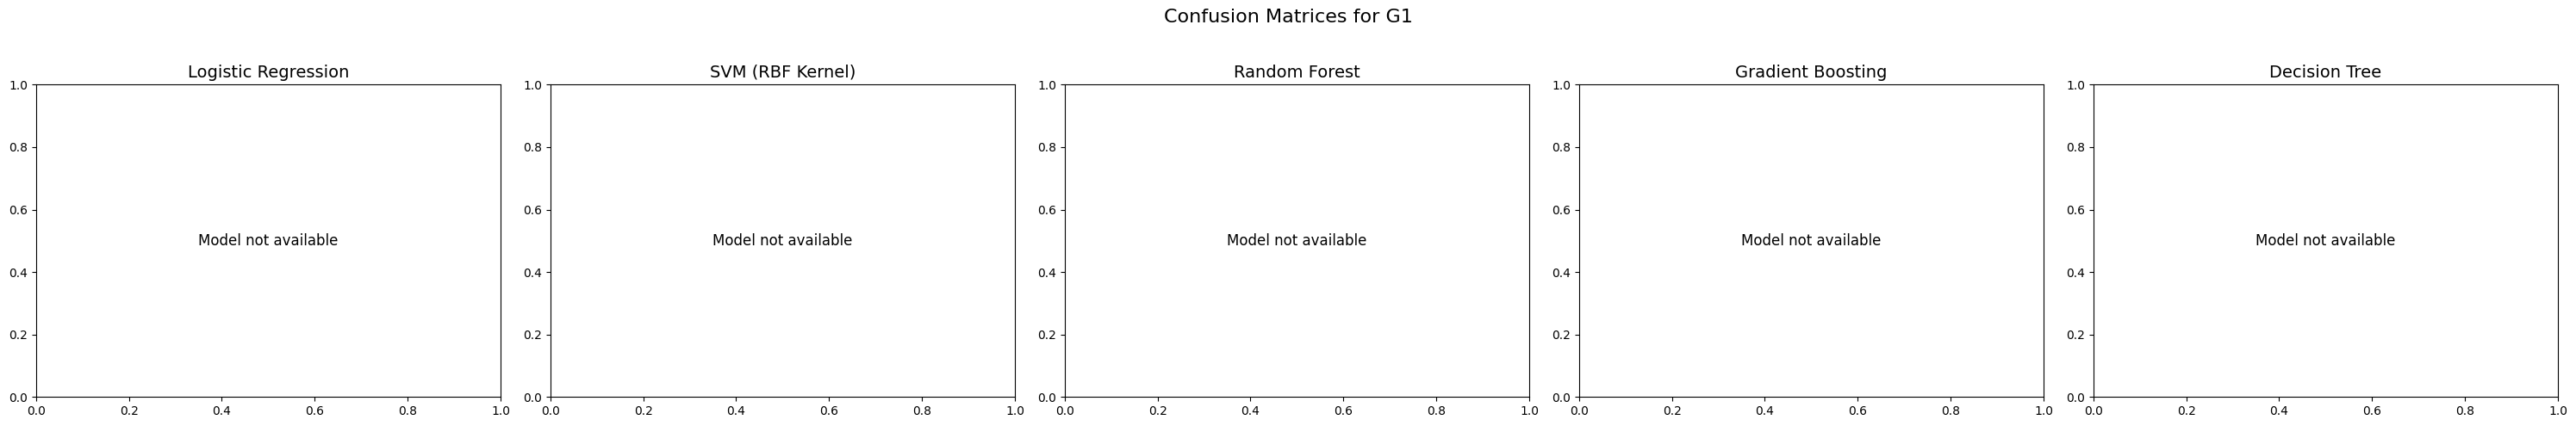

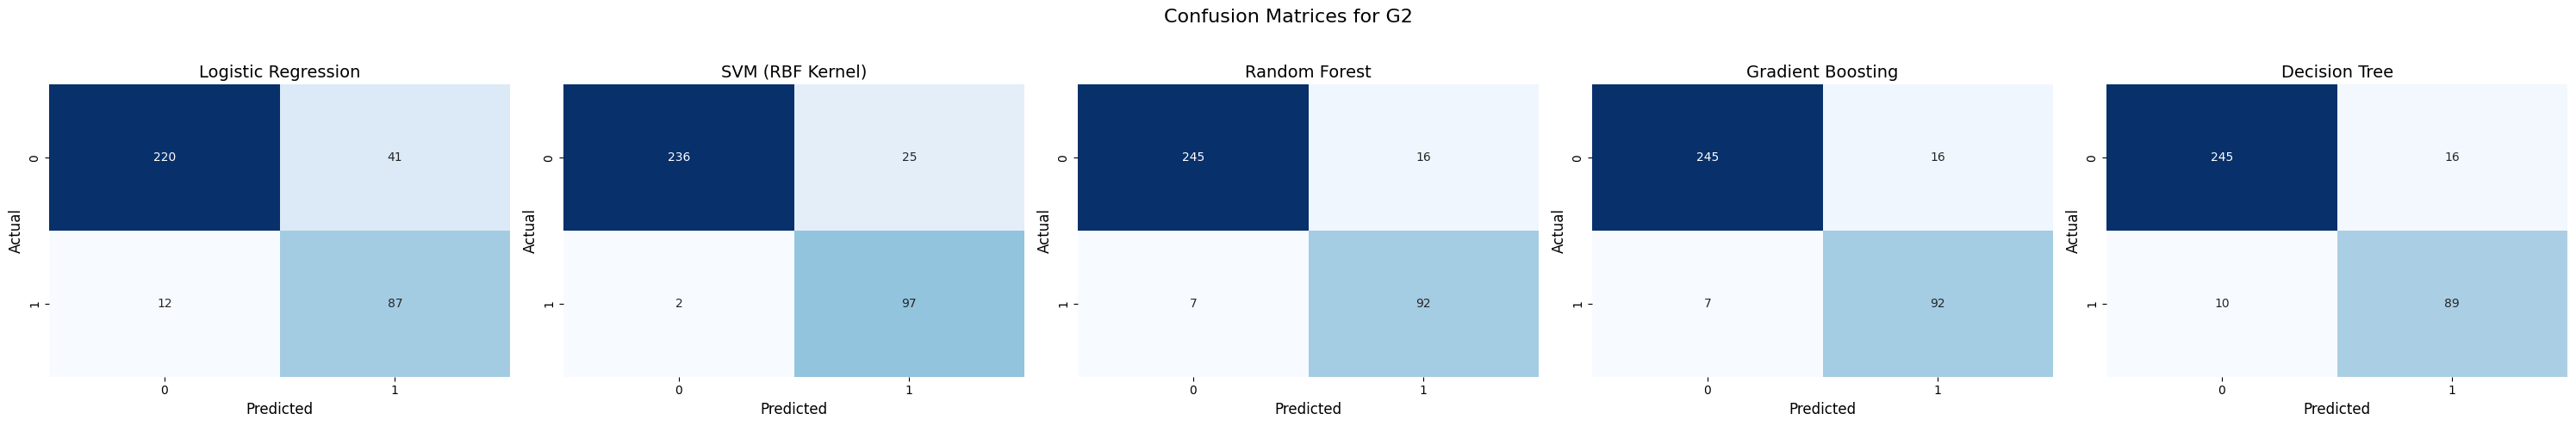

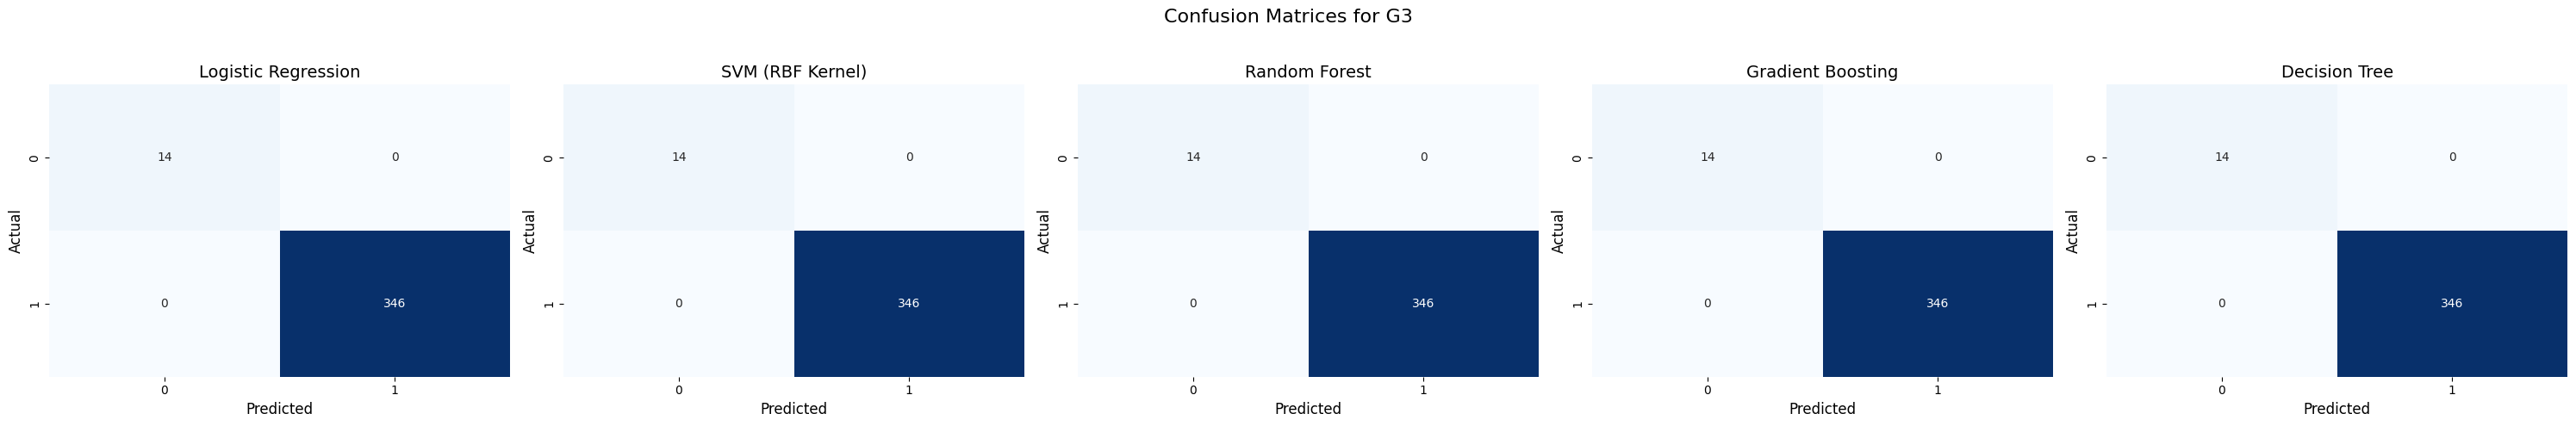

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrices for a unit
def plot_confusion_matrices(X_test, y_test, trained_models, unit_name, models_to_plot):
    """
    Plot confusion matrices for all specified models for a given unit.
    """
    # Check if the unit exists in y_test
    if unit_name not in y_test.columns:
        print(f"Skipping {unit_name} - data not available.")
        return

    # Create subplots
    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(6 * len(models_to_plot), 5))
    fig.suptitle(f'Confusion Matrices for {unit_name}', fontsize=16)

    for i, model_name in enumerate(models_to_plot):
        model = trained_models.get((unit_name, model_name))
        if model:
            # Predict on test data
            y_pred = model.predict(X_test)

            # Compute confusion matrix
            cm = confusion_matrix(y_test[unit_name], y_pred)

            # Plot the confusion matrix
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
            axes[i].set_title(model_name, fontsize=14)
            axes[i].set_xlabel('Predicted', fontsize=12)
            axes[i].set_ylabel('Actual', fontsize=12)
        else:
            axes[i].text(0.5, 0.5, 'Model not available', 
                         horizontalalignment='center', verticalalignment='center', 
                         transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(model_name, fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Models to include in the plots
models_to_plot = [
    'Logistic Regression', 
    'SVM (RBF Kernel)', 
    'Random Forest', 
    'Gradient Boosting', 
    'Decision Tree'
]

# Plot confusion matrices for each unit
for unit in ['G1', 'G2', 'G3']:
    try:
        plot_confusion_matrices(X_test_scaled[unit], y_test, trained_models, unit, models_to_plot)
    except KeyError as e:
        print(f"KeyError encountered for {unit}: {e}")


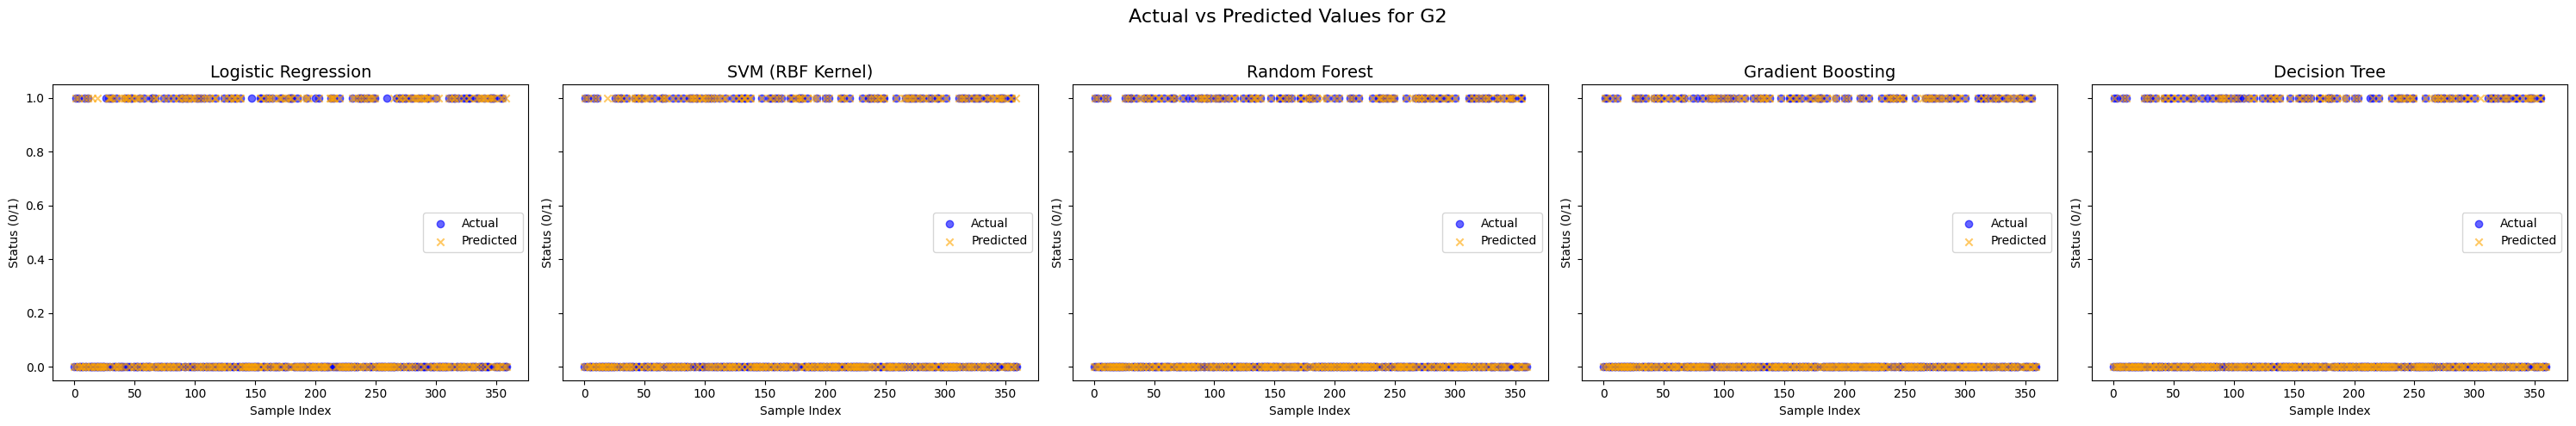

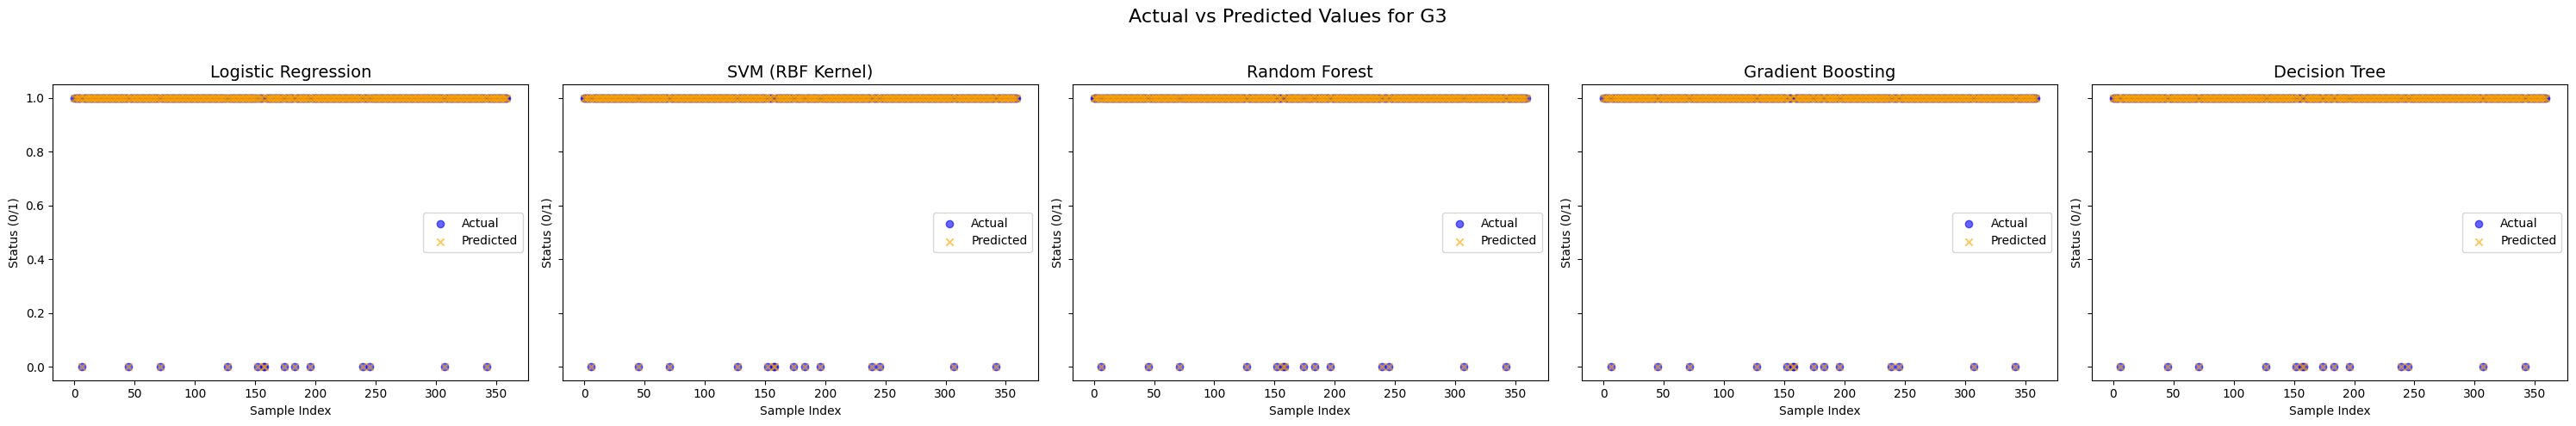

In [31]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted values for each unit and model
def plot_predictions(X_test, y_test, trained_models, unit_name, models_to_plot):
    """
    Plot actual vs predicted values for each unit and specified models.
    """
    # Check if the unit exists in y_test
    if unit_name not in y_test.columns:
        print(f"Skipping {unit_name} - data not available.")
        return

    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(6 * len(models_to_plot), 5), sharey=True)
    fig.suptitle(f'Actual vs Predicted Values for {unit_name}', fontsize=16)

    for i, model_name in enumerate(models_to_plot):
        model = trained_models.get((unit_name, model_name))
        if model:
            y_pred = model.predict(X_test)
            axes[i].scatter(range(len(y_test[unit_name])), y_test[unit_name].values, label='Actual', color='blue', alpha=0.6)
            axes[i].scatter(range(len(y_pred)), y_pred, label='Predicted', color='orange', alpha=0.6, marker='x')
            axes[i].set_title(model_name, fontsize=14)
            axes[i].set_xlabel('Sample Index')
            axes[i].set_ylabel('Status (0/1)')
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, 'Model not available', 
                         horizontalalignment='center', verticalalignment='center', 
                         transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(model_name, fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Models to include in the plots
models_to_plot = [
    'Logistic Regression', 
    'SVM (RBF Kernel)', 
    'Random Forest', 
    'Gradient Boosting', 
    'Decision Tree'
]

# Plot for each unit except G1
for unit in ['G2', 'G3']:
    try:
        plot_predictions(X_test_scaled[unit], y_test, trained_models, unit, models_to_plot)
    except KeyError as e:
        print(f"KeyError encountered for {unit}: {e}")


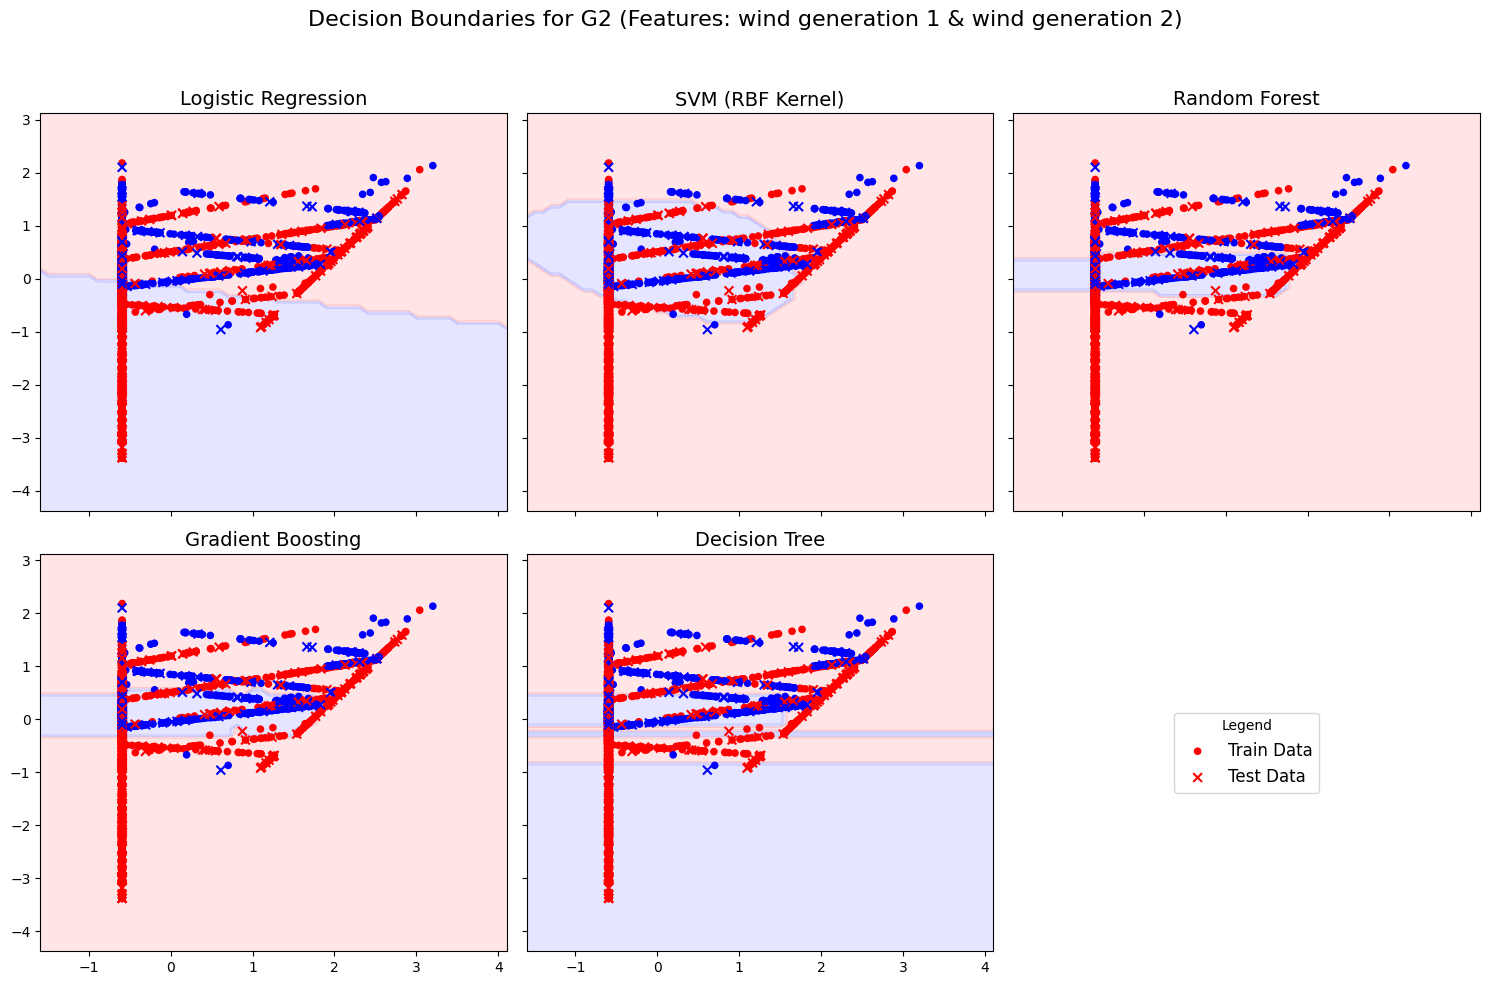

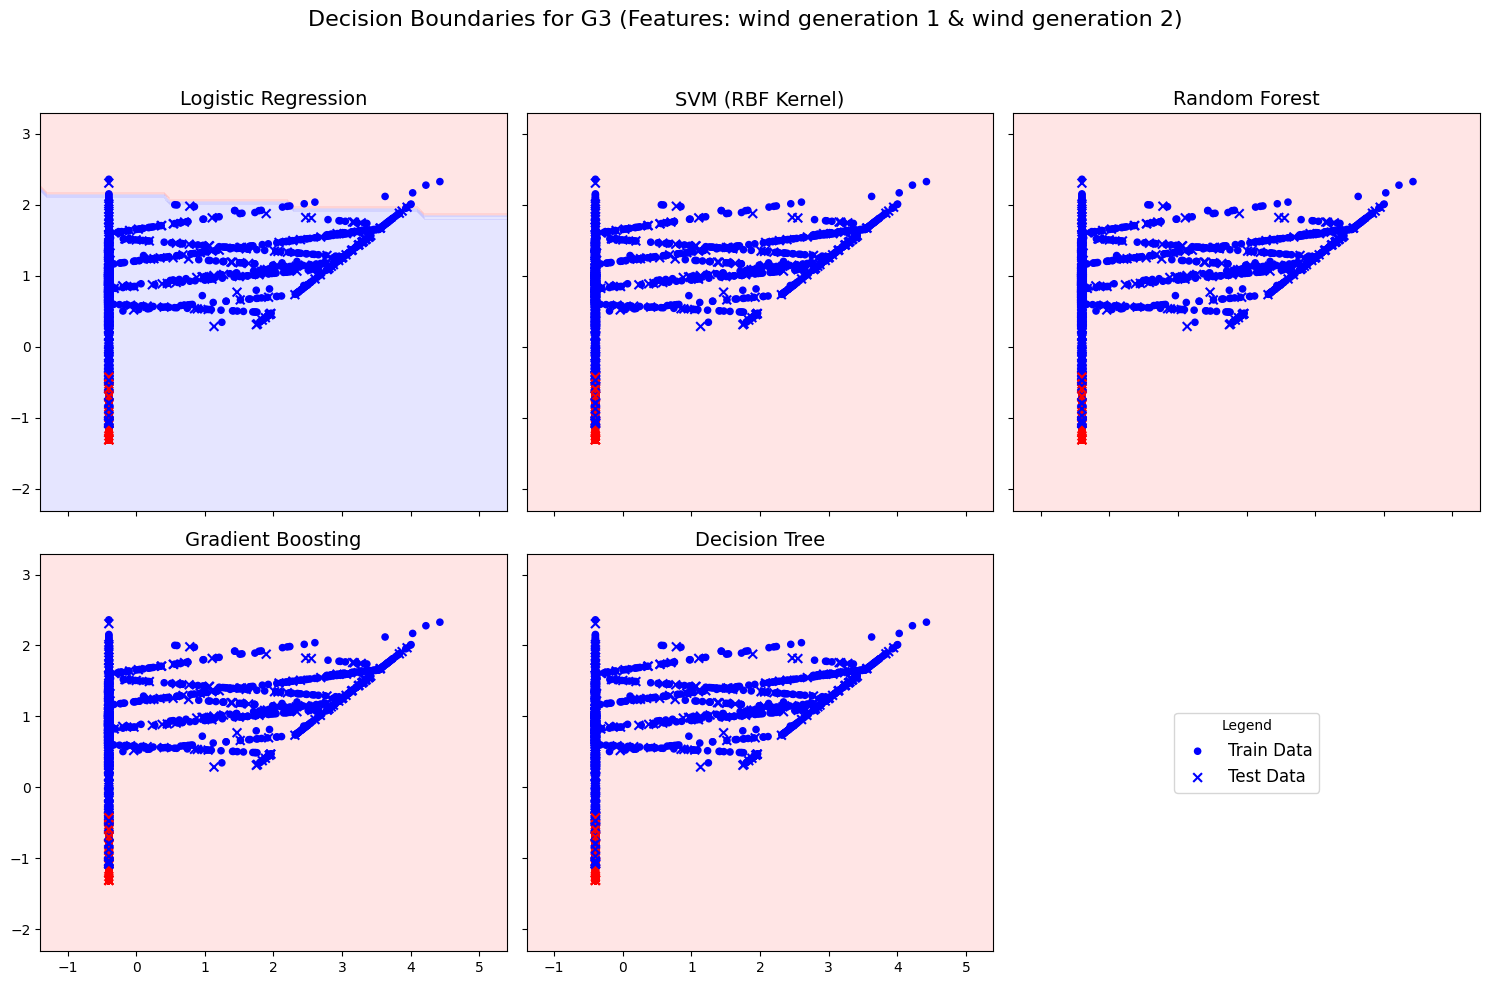

In [34]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Function to plot decision boundaries using pre-trained models
def plot_decision_boundary_all_models(X_train, y_train, X_test, y_test, trained_models, unit_name, features):
    feature_1, feature_2 = features[:2]  # For visualization
    models = [
        'Logistic Regression',
        'SVM (RBF Kernel)',
        'Random Forest',
        'Gradient Boosting',
        'Decision Tree'
    ]
    
    # Create a mesh grid using the first two features
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Expand grid to include all features (fill remaining with mean values)
    grid_full = np.zeros((grid_points.shape[0], X_train.shape[1]))
    grid_full[:, :2] = grid_points
    grid_full[:, 2:] = X_train[:, 2:].mean(axis=0)

    # Initialize plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle(f"Decision Boundaries for {unit_name} (Features: {feature_1} & {feature_2})", fontsize=16)
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ['red', 'blue']

    for i, model_name in enumerate(models):
        ax = axes.flatten()[i]
        if (unit_name, model_name) in trained_models:
            model = trained_models[(unit_name, model_name)]
            
            # Predict on the mesh grid
            Z = model.predict(grid_full)
            Z = Z.reshape(xx.shape)

            # Plot decision boundary
            ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, facecolor='k', s=20, cmap=ListedColormap(cmap_bold), label="Train Data")
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, facecolor='k', marker='x', s=40, cmap=ListedColormap(cmap_bold), label="Test Data")
            ax.set_title(model_name, fontsize=14)
        else:
            ax.text(0.5, 0.5, "Model not available", fontsize=12, ha='center', va='center')
    
    # Add legend to the last subplot
    ax_legend = axes.flatten()[-1]
    ax_legend.axis('off')  # Turn off axes
    handles, labels = ax.get_legend_handles_labels()
    ax_legend.legend(handles, labels, loc='center', fontsize=12, title="Legend")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot decision boundaries for G2 and G3
all_features = ['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']
for unit in ['G2', 'G3']:
    plot_decision_boundary_all_models(
        X_train_scaled[unit], y_train_resampled[unit],
        X_test_scaled[unit], y_test[unit],
        trained_models, unit, all_features
    )
